In [2]:
import hopsworks
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np
from sklearn.metrics import mean_squared_error


/Users/robingoran/miniconda3/envs/lab1serveerless/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [58]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

In [62]:
#Split data
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.29s) 


In [60]:
#Lasso regression

lasso_model = Lasso(alpha=0.01)  # You can adjust the alpha (regularization strength)

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_predict = lasso_model.predict(X_test)

# Evaluate the performance using Mean Squared Error
mse = mean_squared_error(y_test, y_predict)
print("Mean Squared Error:", mse)


print(y_predict)


Mean Squared Error: 0.5658912445856978
[6.1166015  5.92912195 5.56193903 ... 5.77448383 5.38750095 6.23709234]


In [63]:
#Random forest

model = ensemble.RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_leaf=1,
                                         min_samples_split=2, n_estimators=100)


In [64]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [72]:
y_pred = model.predict(X_test)


# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
results = confusion_matrix(y_test, y_pred)


{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, '4': {'precision': 0.6, 'recall': 0.06666666666666667, 'f1-score': 0.12000000000000001, 'support': 45}, '5': {'precision': 0.6482939632545932, 'recall': 0.6482939632545932, 'f1-score': 0.6482939632545932, 'support': 381}, '6': {'precision': 0.523725834797891, 'recall': 0.7061611374407583, 'f1-score': 0.6014127144298689, 'support': 422}, '7': {'precision': 0.6146788990825688, 'recall': 0.3743016759776536, 'f1-score': 0.4652777777777778, 'support': 179}, '8': {'precision': 0.5, 'recall': 0.030303030303030304, 'f1-score': 0.05714285714285715, 'support': 33}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5778611632270169, 'macro avg': {'precision': 0.41238552816215046, 'recall': 0.26081806766324317, 'f1-score': 0.27030390180072816, 'support': 1066}, 'weighted avg': {'precision': 0.5830579973925796, 'recall': 0.5778611632270169, 'f1-score': 0.5547529099412206, 'support': 1066}}


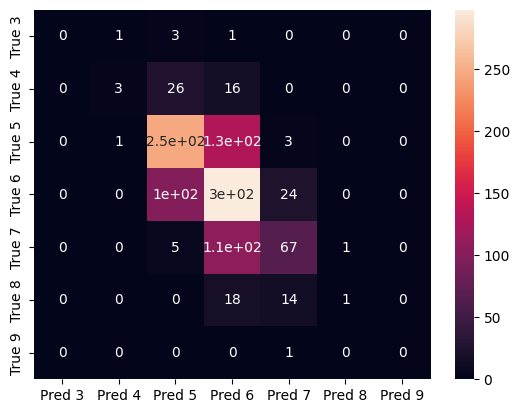

In [73]:
#Dålig på 5,6,7 - lika varandra? Var är 9?
print(metrics)

df_cm = pd.DataFrame(results, ['True 3', 'True 4', 'True 5', 'True 6','True 7','True 8', 'True 9'],
                     ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
#df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [74]:
mr = project.get_model_registry()


model_dir="wine_model"

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"Accuracy" : metrics['weighted avg']['precision'] },
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 27853/27853 elapsed<00:01 remaining<00:001,  3.00it/s]
Uploading: 100.000%|██████████| 25331777/25331777 elapsed<00:22 remaining<00:0000it/s]
Uploading: 100.000%|██████████| 1070/1070 elapsed<00:01 remaining<00:000:57, 14.41s/it]
Model export complete: 100%|██████████| 6/6 [00:31<00:00,  5.23s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/224406/models/wine_model/1


Model(name: 'wine_model', version: 1)